In [147]:
import torch
import numpy as np 
from gpssm.models.components.gp import ExactGPModel, VariationalGP, ModelList
from gpssm.models.components.emissions import Emissions
import gpytorch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.mlls import ExactMarginalLogLikelihood, VariationalELBO
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
def plot_predictions(train_x, train_y, test_x, pred_y):
    dim_y = len(pred_y)
    fig, axes = plt.subplots(dim_y, 1, figsize=(8, 8))
    if dim_y == 1:
        axes = [axes]
    for iy in range(dim_y):
        lower, upper = pred_y[iy].confidence_region()
        lower = lower.detach()
        upper = upper.detach()
        axes[iy].plot(train_x[:, 0], train_y[iy], 'k*')

        idx = test_x[:, 0].argsort()
        axes[iy].plot(test_x[idx, 0], pred_y[iy].mean[idx].detach(), 'b')
        axes[iy].fill_between(test_x[idx, 0], lower[idx], upper[idx], alpha=0.5)

        axes[iy].legend(['Observed Data', 'Mean', 'Confidence'])
        axes[iy].set_title('Observed Values (Likelihood)')

        axes[iy].set_xlabel('x')
        axes[iy].set_ylabel('y_{}'.format(iy))
    plt.show()


    
def plot_losses(losses):
    plt.figure(figsize=(8, 4))
    plt.plot(losses, 'k-')
    plt.xlabel('Iteration Number')
    plt.ylabel('Marginal Log-Likelihood')
    plt.show()



# Generate data

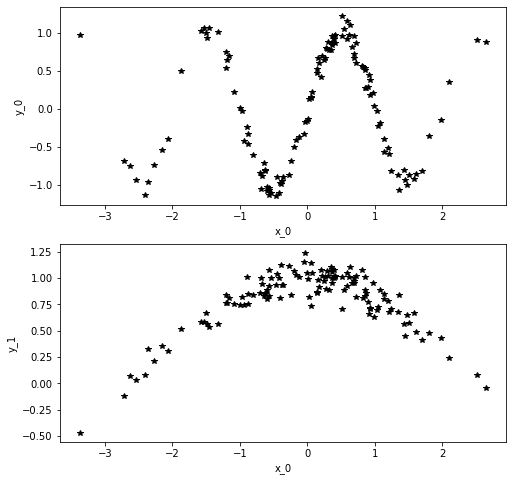

In [149]:
dim_x = 3
dim_y = 2
num_points = 128
x = torch.randn((num_points, dim_x))

y1 = (torch.sin(np.pi * x[:, 0]) + 0 * x[:, 2] - 0 * x[:, 1] ** 2).unsqueeze(
    dim=1)
y2 = (torch.cos(np.pi / 5 * x[:, 0]) - 0 * x[:, 2] ** 2 + 0 * x[:, 1]).unsqueeze(
    dim=1)
y = torch.cat((y1, y2), dim=-1) + 0.1 * torch.randn((num_points, dim_y))

y = y[:, :dim_y]
y = y.t()

fig, axes = plt.subplots(dim_y, 1, figsize=(8, 8))
if dim_y == 1:
    axes = [axes]
for iy in range(dim_y):
    axes[iy].plot(x[:, 0], y[iy], 'k*')
    axes[iy].set_xlabel('x_0')
    axes[iy].set_ylabel('y_{}'.format(iy))

plt.show()


# Split Train/Test Data
train_x, test_x = x[:(num_points // 2)], x[(num_points // 2):]
train_y, test_y = y[:, :(num_points // 2)], y[:, (num_points // 2):]


# Exact GP Model 
 

In [154]:
# Set up likelihood, mean, and Kernel functions.
models = []
likelihoods = []
for iy in range(dim_y):
    ip = torch.randn((num_points, dim_x))
    likelihood_ = GaussianLikelihood()
    mean = ConstantMean()
    kernel = ScaleKernel(RBFKernel(ard_num_dims=3))
    model_ = ExactGPModel(train_x, train_y[iy], likelihood_, mean, kernel)
    models.append(model_)
    likelihoods.append(likelihood_)

models = ModelList(models)
likelihoods = Emissions(likelihoods)

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': models.parameters()},
], lr=0.1)

print(models)
print(likelihoods)

# Train
models.train()
likelihoods.train()
losses = []
for iter_ in range(50):
    # Zero gradients from previous iteration
    optimizer.zero_grad()

    # Output from model
    output = models(train_x)
    pred_y = likelihoods(output)

    # Calculate loss 
    loss = torch.tensor(0.)
    for iy in range(dim_y):
        loss -= pred_y[iy].log_prob(train_y[iy]).squeeze()
   
    # Backpropagate gradients
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
# Predict by feeding model through likelihood
models.eval()
likelihoods.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    output = models(test_x)  # [m(test_x) for m in models.models]
    pred_y = likelihoods(output)

print(models)
print(likelihoods)

component 0 outputscale: 0.6931471824645996, lengthscale: tensor([[0.6931, 0.6931, 0.6931]])component 1 outputscale: 0.6931471824645996, lengthscale: tensor([[0.6931, 0.6931, 0.6931]])
component 0 tensor([0.6932])component 1 tensor([0.6932])
component 0 outputscale: 0.3285789489746094, lengthscale: tensor([[0.4613, 4.7954, 4.6352]])component 1 outputscale: 0.0561184287071228, lengthscale: tensor([[1.3227, 4.0436, 4.0329]])
component 0 tensor([0.0088])component 1 tensor([0.0089])


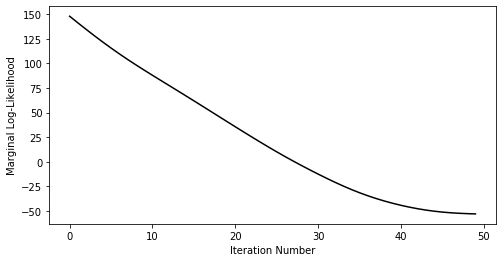

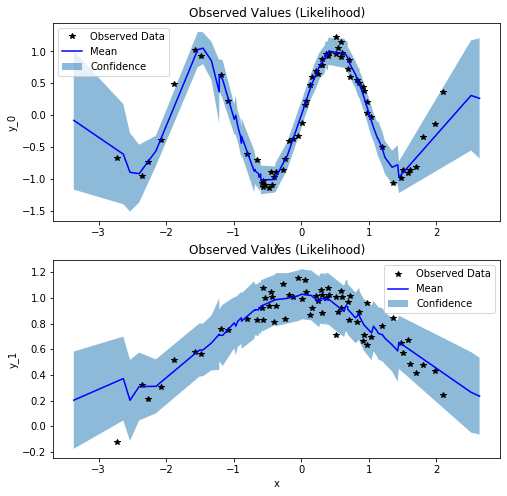

In [153]:
plot_losses(losses)
plot_predictions(train_x, train_y, test_x, pred_y)

# Variational GP Model 

In [155]:
num_inducing_points = 25
learn_inducing_loc = False

models = []
likelihoods = []
for iy in range(dim_y):
    inducing_points = torch.randn(num_inducing_points, dim_x)
    likelihood_ = GaussianLikelihood()
    mean = ConstantMean()
    kernel = ScaleKernel(RBFKernel(ard_num_dims=3))
    model_ = VariationalGP(inducing_points, mean, kernel, learn_inducing_loc)
    models.append(model_)
    likelihoods.append(likelihood_)

models = ModelList(models)
likelihoods = Emissions(likelihoods)

# Use the adam optimizer
optimizer = torch.optim.Adam([
        {'params': models.parameters()},
        {'params': likelihoods.parameters()},
    ], lr=0.05)

print(models)
print(likelihoods)

# Train
models.train()
likelihoods.train()
losses = []
for iter_ in range(200):
    # Zero gradients from previous iteration
    optimizer.zero_grad()

    # Output from model
    output = models(train_x)
    pred_y = likelihoods(output)

    # Calculate loss 
    loss = torch.tensor(0.)
    for iy in range(dim_y):
        loglik = likelihoods.likelihoods[iy].expected_log_prob(train_y[iy],
                                                               output[iy])
        kl = models.models[iy].variational_strategy.kl_divergence()

        loss += -(loglik - kl).squeeze()
   
    # Backpropagate gradients
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
# Predict by feeding model through likelihood
models.eval()
likelihoods.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    output = models(test_x)  # [m(test_x) for m in models.models]
    pred_y = likelihoods(output)

print(models)
print(likelihoods)


component 0 outputscale: 0.6931471824645996, lengthscale: tensor([[0.6931, 0.6931, 0.6931]])component 1 outputscale: 0.6931471824645996, lengthscale: tensor([[0.6931, 0.6931, 0.6931]])
component 0 tensor([0.6932])component 1 tensor([0.6932])
component 0 outputscale: 0.40494340658187866, lengthscale: tensor([[0.6155, 8.2822, 8.2897]])component 1 outputscale: 0.12324924767017365, lengthscale: tensor([[1.9442, 7.3204, 8.3509]])
component 0 tensor([0.0314])component 1 tensor([0.0110])


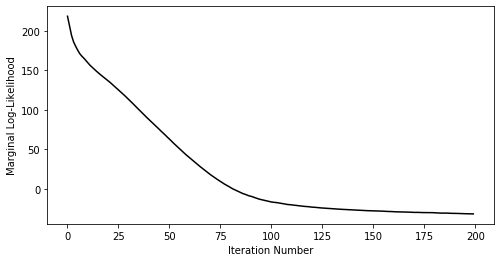

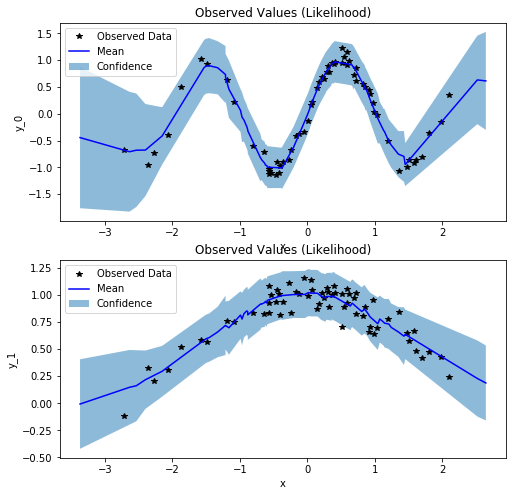

In [156]:
plot_losses(losses)
plot_predictions(train_x, train_y, test_x, pred_y)

# Sample Exact GP from Variational GP


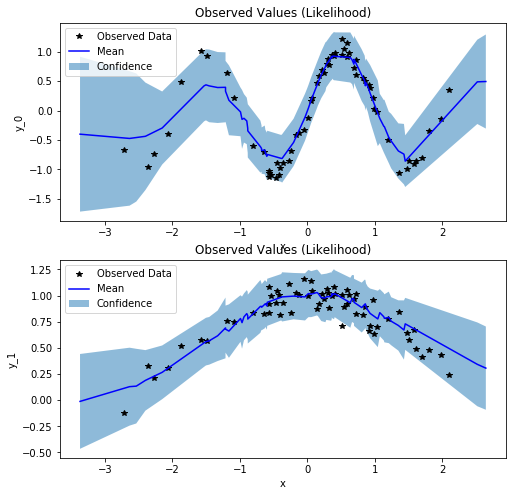

In [158]:
sampled_models = models.sample_gp(likelihoods.likelihoods)
sampled_models.eval()
likelihoods.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    output = sampled_models(test_x)  # [m(test_x) for m in models.models]
    pred_y = likelihoods(output)

plot_predictions(train_x, train_y, test_x, pred_y)